### HW2

#### CS208
#### Lipika Ramaswamy

https://github.com/lipikaramaswamy/cs208_lr/tree/master/homework/HW3

### R imports

In [1]:
## Setup
# rm(list=ls())
library(ggplot2)
library(repr)

In [2]:
### Using James's functions

# Random draw from Laplace distribution
#
# mu numeric, center of the distribution
# b numeric, spread
# size integer, number of draws
# 
# return Random draws from Laplace distribution
# example:
# 
# rlap(size=1000)

rlap = function(mu=0, b=1, size=1) {
    p <- runif(size) - 0.5
    draws <- mu - b * sgn(p) * log(1 - 2 * abs(p))
    return(draws)
}


# Probability density for Laplace distribution
#
# x numeric, value
# mu numeric, center of the distribution
# b numeric, spread
# 
# return Density for elements of x
# example:
# 
# x <- seq(-3, 3, length.out=61)
# dlap(x)

dlap <- function(x, mu=0, b=1) {
    dens <- 0.5 * b * exp(-1 * abs(x - mu) / b)
    return(dens)
}


# Laplace Cumulative Distribution Function
# 
# Determines the probability a draw from a LaPlace distribution is less than 
#    or equal to the specified value.
#
# x Numeric, the value(s) at which the user wants to know the CDF height.
# mu Numeric, the center of the LaPlace distribution, defaults to 0.
# b Numeric, the spread of the LaPlace distribution, defaults to 1.
# 
# return Probability the LaPlace draw is less than or equal to \code{x}.
# example:
# 
# x <- 0
# plap(x)

plap <- function(x, mu=0, b=1) {
    cdf <- 0.5 + 0.5 * sgn(x - mu) * (1 - exp(-1 * (abs(x - mu) / b)))
    return(cdf)
}


# Quantile function for Laplace distribution
#
# p Numeric, vector of probabilities
# mu numeric, center of the distribution
# b numeric, spread
# return Quantile function
# example:
#
# probs <- c(0.05, 0.50, 0.95)
# qlap(probs)

qlap <- function(p, mu=0, b=1) {
    q <- ifelse(p < 0.5, mu + b * log(2 * p), mu - b * log(2 - 2 * p))
    return(q)
}

# Sign function
# 
# Function to determine what the sign of the passed values should be.
#
# x numeric, value or vector or values
# return The sign of passed values
# example:
#
# sgn(rnorm(10))


sgn <- function(x) {
    return(ifelse(x < 0, -1, 1))
}

### Problem 1: 

### (a)
<img src="q1_a.png" alt="Drawing" style="width: 700px;">


First, we will show that the transformation of trimming data is 1-Lipschitz. Then, we will use the fact that the mechanism of Laplace noise added to the mean is $\epsilon$-DP and that the composition of this mechanism and the transformation is $(1\times \epsilon)$-DP.

**1:**  

Consider the ordered datasets:
$x = \{x_1, x_2,\ldots, x_{n-1}, x_n \}$ of size n and $x = \{x_2, x_3,\ldots, x_{n}, x_{n+1} \}$ of size n, where $x$ and $x'$ difer on one element only corresponding to the most extreme change in the mean. So, $d(x,x')=1$.
  
Let T be the transformation of trimming the data to the middle 90 percentile.  Let $x_{p^5}$ be the data point at the 5th percentile and $x_{p^{95}}$ be the data point at the 95th percentile. Then, $T(x) = \{ x_{p^5}, \ldots, x_{p^{95}} \}$ and $T(x') = \{ x_{p^5 + 1}, \ldots, x_{p^{95} + 1} \}$. These two datasets only differ on one element, so $d(T(x),T(x'))=1$.

By definition, a mapping from datasets to datasets is c-Lipshitz iff: 
$\forall x, x', d(T(x), T(x')) \le c \cdot d(x, x')$.

For arbitrary $x, x'$, we showed that $c=1$. Hence, by definition, the mapping T is 1-Lipschitz.

**2:**  

Consider the mechanism below:
$$ M' = \frac{1}{n'} \cdot \left( \sum_{i = 1}^{n'} x_i \right) + Lap \left( \frac{D}{\varepsilon n'} \right)$$
Adding Laplace noise with scale equal to the global sensitivity of the mechanism divided by the privacy loss, i.e. $\frac{GS}{\varepsilon}$, to a mean is $\varepsilon$-DP, as shown in class and referred to in the last homework. Here, the global sensitivity for the mean is $\frac{D-0}{n'}$, where n' is the size of the dataset. The noise is being drawn from a Laplace distribution with scale $\frac{D}{\varepsilon n'}$. Thus, this mechanism is $\varepsilon$-DP.

**3:**

By a lemma, we know that if a mechanism M' is $\varepsilon$-DP and a transformation T is c-Lipschitz, then M'$\circ $T is a $c \varepsilon$-DP mechanism.

Here, we have the above mechanism M' and transformation T, which is 1-Lipschitz, so the composition is $\varepsilon$-DP, i.e.:  
$$M(x) = M' \circ  T(x) = \frac{1}{.9n'} \cdot \left( \sum_{P_{.05} \le x_i \le P_{.95}} x_i \right) + Lap \left( \frac{D}{.9 \varepsilon n'} \right) \text{ is $\varepsilon$-DP.}$$

In [3]:
## trim variable to a range


# Trimming helper function
# 
# Determines the probability a draw from a LaPlace distribution is less than 
#    or equal to the specified value.
#
# x - vector/column/list to be trimmed
# lower - 
# b Numeric, the spread of the LaPlace distribution, defaults to 1.
# 
# return Probability the LaPlace draw is less than or equal to \code{x}.
# example:
# 
# x <- 0
# plap(x)
 
trim <- function(x, lower, upper){    
    x.trim <- x
    x.trim <- x.trim[x.trim<upper]
    x.trim <- x.trim[x.trim>lower]
    return(x.trim)
}

## DP trimmed mean release function
trimmedMeanRelease <- function(x, epsilon, D, n){

    upper <- quantile(x, probs = 0.95)
    lower <- quantile(x, probs = 0.05)
    
    trimmed.x <- trim(x, lower, upper)
    
    sensitivity <- D / (length(trimmed.x))
    scale <- sensitivity / epsilon
    
    sensitiveValue <- mean(trimmed.x)
    
    DPrelease <- sensitiveValue + rlap(mu=0, b=scale, size=1)
    
    return(list(release=DPrelease, true=sensitiveValue, n_rows = length(trimmed.x)))
}

In [230]:
## Testing trimmed mean

# make some fake natural number valued data of size 100
x.testing <- sample.int(100, 100, replace = TRUE)

# check that fn works
trimmedMeanRelease(x.testing, 1, 100 , 100)

$release
[1] 48.67091

$true
[1] 46.82222

$n_rows
[1] 90


### (b)
<img src="q1_b.png" alt="Drawing" style="width: 700px;">


First, we will show that the transformation of trimming data is 0.1n-Lipschitz. Then, we will use the fact that the mechanism of Laplace noise added to the mean is $\varepsilon$-DP and that the composition of this mechanism and the transformation is $(0.1n\times \varepsilon)$-DP, which is not $\varepsilon$-DP.

**1:**  

Consider the ordered datasets:
$x = \{x_1, x_2,\ldots, x_{n-1}, x_n \}$ of size n and $x'$ to be another dataset of size n, where $x$ and $x'$ difer on one element, where, in x', the value of the 5th percentile has been changed to a value above the 95th percentile. So, $d(x,x')=1$.
  
Let T be the transformation of clamping/Winsorizing the data to the middle 90 percentile.  Let $x_{p^5}$ be the data point at the 5th percentile and $x_{p^{95}}$ be the data point at the 95th percentile in dataset x and $x'_{p^5}$ be the data point at the 5th percentile and $x'_{p^{95}}$ be the data point at the 95th percentile in dataset x'. Then, $T(x) = \{ x_{p^5},  \ldots , x_{p^5}, x_{p^5}, \ldots, x_{p^{95}}, x_{p^{95}}, x_{p^{95}},  \ldots , x_{p^{95}} \}$ where the values below the 5th percentile get clamped to $x_{p^{5}}$ and the values above the 9th percentile get clamped to $x_{p^{95}}$. There are $0.05 \times n$ such values below the 5th percentile and $0.05 \times n $ values above the 95th percentile. Similarly, $T(x') = \{ x'_{p^5},  \ldots , x'_{p^5}, x'_{p^5}, \ldots, x'_{p^{95}}, x'_{p^{95}}, x'_{p^{95}},  \ldots , x'_{p^{95}} \}$ where the values below the 5th percentile get clamped to $x'_{p^{5}}$ and the values above the 9th percentile get clamped to $x'_{p^{95}}$. There are $0.05 \times n$ such values below the 5th percentile and $0.05 \times n $ values above the 95th percentile. 

These two datasets (T(x) and T(x')) now differ on $0.05n + 0.05n = 0.1n$ rows, so $d(T(x),T(x'))=0.1n$.

By definition, a mapping from datasets to datasets is c-Lipshitz iff: 
$\forall x, x', d(T(x), T(x')) \le c \cdot d(x, x')$.

For arbitrary $x, x'$, we showed that $c=0.1n$. Hence, by definition, the mapping T is $0.1n$-Lipschitz.

**2:**  

Consider the mechanism below:
$$ M' = \frac{1}{n} \cdot \left( \sum_{i = 1}^{n} x_i \right) + Lap \left( \frac{D}{\varepsilon n} \right)$$
Adding Laplace noise with scale equal to the global sensitivity of the mechanism divided by the privacy loss, i.e. $\frac{GS}{\varepsilon}$, to a mean is $\varepsilon$-DP, as shown in class and referred to in the last homework. Here, the global sensitivity for the mean is $\frac{D-0}{n}$, where n is the size of the dataset. The noise is being drawn from a Laplace distribution with scale $\frac{D}{\varepsilon n}$. Thus, this mechanism is $\varepsilon$-DP.

**3:**

By a lemma, we know that if a mechanism M' is $\varepsilon$-DP and a transformation T is c-Lipschitz, then M'$\circ $T is a $c \varepsilon$-DP mechanism.

Here, we have the above mechanism M' and transformation T, which is 0.1n-Lipschitz, so the composition is $0.1n \varepsilon$-DP, i.e.:  
$$M(x) = M' \circ  T(x) = \frac{1}{n} \cdot \left( \sum_{i=1}^n [x_i]_{P_{0.05}}^{P_{0.95}} \right) + Lap \left( \frac{D}{.9 \varepsilon n'} \right) \text{ is $0.1n \varepsilon$-DP.}$$

This is therefore not $\varepsilon$-DP.


### (c)
<img src="q1_c.png" alt="Drawing" style="width: 700px;">


An exponential mechanism to release the median is one that releases an estimate of the 50th percentile of the dataset. We now alter this mechanism to release an estimate of the $t^{th}$ percentile. We will use the following utility function:

$$u(x,y) = - | n \cdot t - \text{# \{ i : }x_i \le y \} | $$

In [5]:
## Bound/Censor/Clip a variable to a range
clip <- function(x, lower, upper){
    x.clipped <- x
    x.clipped[x.clipped<lower] <- lower
    x.clipped[x.clipped>upper] <- upper
    return(x.clipped)
}

In [10]:
percentileRelease <- function(x, epsilon, t){
    # get length of data
    n <- length(x)
    
    # populate nbins
    bins <- sort(x)
    nbins <- length(bins)
    
    # get the t-th quantile 
    sensitiveValue <- quantile(x, probs = t)

    # empty vector to store utility scores
    likelihoods <- rep(NA, nbins)
    
    # calculate utility scores
    for(i in 1:length(likelihoods)){
        
        # multiply through by n to make GS_u = 1
        utility <- - abs(n*t - i)
        
        # for weighting the bins propotional to the number of elements in it
        dist <- 1
        if (i < n){
            
            # accounting for values that aren't present in the data and weighting the bins
            dist = abs(x[i] - x[i+1]) + 1
        }
        likelihoods[i] <-  dist * exp(epsilon * utility/ 2) 
    }
    
    # calculate probability
    probabilities <- likelihoods/sum(likelihoods)
    
    # compare probability vector to a random uniform draw between 0 and 1
    flag <- runif(n=1, min=0, max=1) < cumsum(probabilities)
    
    ## sample uniformly from the bin
    indices.of.bins <- which(flag == 1)
    
    if(sum(flag) > 1){
        min.runif <- bins[indices.of.bins[1]]
        max.runif <- bins[indices.of.bins[1] + 1] 
        DPrelease <- runif(n=1, min=min.runif, max=max.runif)
    }
    # in the case that we're in the last bin
    else{
        DPrelease <- bins[indices.of.bins[1]]
    }
    return(list(release=DPrelease, true=sensitiveValue))
}


### Example of release for 10th percentile - distribution of released value

In the simulation below, integers in the range of 1 to 100 are randomly sampled as a dataset and the 40th percentile is released using a DP mechanism. This DP release is performed for 10,000 simulations. The true values are also saved and the true value is plotted as the blue line. The histogram shows that the DP release of the 40th percentile peaks around the true 40th percentile averaged across all the simulations, and the distribution is symmetric, as expected from the construction of the mechanism.

In [11]:
## Testing distribution of the 10th percentile releases
history <- rep(NA, 10000)
trueHistory <- rep(NA, 10000)

# Make dataset
x <- sample.int(100, 1000, replace = TRUE)

for(i in 1:10000){
    # Do percentile release - 10th percentile
    release <- percentileRelease(x, epsilon = 0.5, t = 0.4)
    history[i] <- release$release
    trueHistory[i] <- release$true
}

In [12]:
# plotting this histogram 
for.percentile <- data.frame(history, trueHistory)
p <- ggplot(for.percentile, aes(x=history)) + 
    geom_histogram(color="black", fill="white", binwidth = 1) + 
    geom_vline(aes(xintercept=mean(trueHistory)),
            color="blue", linetype="dashed", size=0.5)+
    labs(x = "40th percentile release", y = 'Frequency', title = 
         'Distribution of differentially private releases of 40th percentile') + 
    theme(plot.title = element_text(hjust = 0.5))

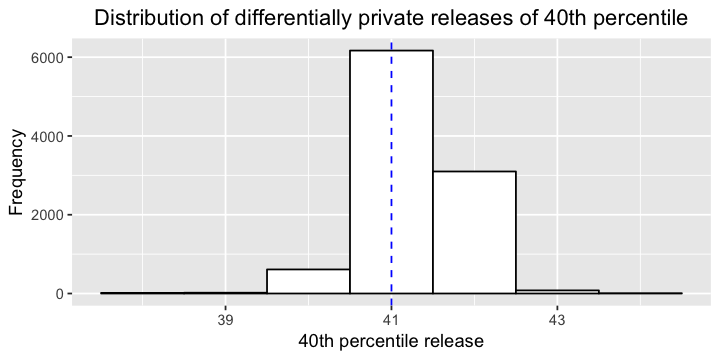

In [13]:
options(repr.plot.width=6, repr.plot.height=3)
p


### (d)
<img src="q1_d.png" alt="Drawing" style="width: 700px;">


In [25]:
## DP trimmed mean release function
trimmedMeanReleaseNew <- function(x, epsilon,
                               lowerPercentileCutoff = 0.05, upperPercentileCutoff = 0.95){

    upper <- percentileRelease(x, epsilon = epsilon/3, t = upperPercentileCutoff)
    lower <- percentileRelease(x, epsilon = epsilon/3, t = lowerPercentileCutoff)
    
    trimmed.x <- trim(x, lower$release, upper$release)
    
    sensitivity <- (upper$release - lower$release ) / (length(trimmed.x))
    scale <- sensitivity / (epsilon/3)    
    sensitiveValue <- mean(trimmed.x)
    
    DPrelease <- sensitiveValue + rlap(mu=0, b=scale, size=1)
    
    return(list(release=DPrelease, true=sensitiveValue))
}

In [26]:
trimmedMeanReleaseNew(x , epsilon = 0.5)

$release
[1] 48.89995

$true
[1] 49.8879

In [27]:
## Testing distribution of the 10th percentile releases
history.d <- rep(NA, 10000)
trueHistory.d <- rep(NA, 10000)

# Make dataset
x.d <- sample.int(100, 1000, replace = TRUE)

for(i in 1:10000){
    # Do percentile release - 10th percentile
    release.d <- trimmedMeanReleaseNew(x.d, epsilon = 0.5)
    history.d[i] <- release.d$release
    trueHistory.d[i] <- release.d$true
}

In [28]:
# plotting this histogram 
for.percentile.d <- data.frame(history.d, trueHistory.d)
p1 <- ggplot(for.percentile.d, aes(x=history.d)) + 
    geom_histogram(color="black", fill="white", binwidth = 1) + 
    geom_vline(aes(xintercept=mean(trueHistory.d)),
            color="blue", linetype="dashed", size=0.5)+
    labs(x = "40th percentile release", y = 'Frequency', title = 
         'Distribution of differentially private releases of the mean (50.23)') + 
    theme(plot.title = element_text(hjust = 0.5))

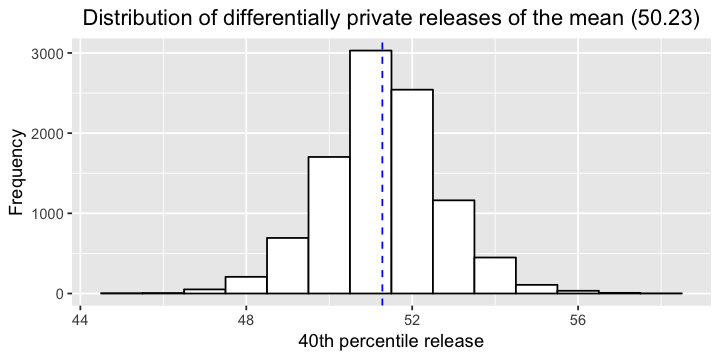

In [29]:
p1


### (e)
<img src="q1_e.png" alt="Drawing" style="width: 700px;">


### (f)
<img src="q1_f.png" alt="Drawing" style="width: 700px;">


In [16]:
# import data
library("foreign")
PUMSdata <- read.csv(file=
                     "https://raw.githubusercontent.com/privacytoolsproject/cs208/master/data/MaPUMS5full.csv")
data.inc <- (PUMSdata$income)

# get true mean of income
true.mean<- mean(data.inc)

In [50]:
## (i) SIMPLE LAPLACE NOISE

## Bound/Censor/Clip/Clamp a variable to a range
clip <- function(x, lower, upper){
    x.clipped <- x
    x.clipped[x.clipped<lower] <- lower
    x.clipped[x.clipped>upper] <- upper
    return(x.clipped)
}

## Differentially private mean release
basicMeanRelease <- function(x, lower, upper, epsilon){
    n <- length(x)
    sensitivity <- (upper - lower)/n
    scale <- sensitivity / epsilon
    x.clipped <- clip(x, lower, upper)
    sensitiveValue <- mean(x.clipped)
    DPrelease <- sensitiveValue + rlap(mu=0, b=scale, size=1)
    return(list(release=DPrelease, true=sensitiveValue))
}

In [130]:
## Get all puma regions
all.pumas <- unique(PUMSdata$puma)
n.iter <- 100

## Set parameters for the mean releases
myeps <- 1
myD <- 1e+06

history <- matrix(NA, nrow = length(all.pumas)*n.iter * 2, ncol = 5)
## COLS structure
# puma  iter  method           DPmean  truemean
#             1 = basic
#             2 = trimmed  

counter = 1

## For loop for 100 iterations of getting DP releases (lap and exp) 
for(one.puma in all.pumas){
    
    ## subset df to the puma region
    puma.df <- PUMSdata[PUMSdata$puma == one.puma,]
    puma.inc <- (puma.df$income)
    
    ## Real mean
    true.mean <- mean(puma.inc)
    
    for(i in 1:n.iter){
        
        ## Do DP mean releases
        basic.release <- basicMeanRelease(x = puma.inc, lower = 0, upper = myD, epsilon = myeps)
        trimmed.release <- trimmedMeanReleaseNew(x = puma.inc, epsilon = myeps)
        
        # store vals
        history[counter,] = c(one.puma, i, 1, basic.release$release, true.mean)
        history[counter+1,] = c(one.puma, i, 2, trimmed.release$release, true.mean)
        
        # update counter
        counter = counter + 2
    }
}

In [131]:
history[1:10,]

100,1,1,27329.79,27293.77
100,1,2,22642.09,27293.77
100,2,1,28099.48,27293.77
100,2,2,22696.77,27293.77
100,3,1,27192.33,27293.77
100,3,2,22880.24,27293.77
100,4,1,27273.01,27293.77
100,4,2,22761.02,27293.77
100,5,1,27347.05,27293.77
100,5,2,22605.61,27293.77


In [133]:
# make a df of the matrix
history.df <- data.frame(history)
names(history.df) <- c("puma", "iteration", "method", "DPmean", "truemean")
# history.df

In [304]:
# utility function to calculate RMSE
calcRMSE <- function(true.col, pred.col){
    error = (true.col-pred.col)
    errorsq = error ** 2
    RMSE = sqrt(sum(errorsq) / length(true.col))
    return(RMSE)
}

Clearly, the RMSE of the 
>> 

In [226]:
pp1 <- ggplot(data = history.df[history.df$method == 1, ], 
            aes(x=reorder(factor(puma), truemean), y=DPmean)) + 
    geom_boxplot(lwd = 0.1, outlier.size = 0.5)+ 
    theme(plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 90, hjust = 1), 
          panel.background = element_rect(fill = "white", colour = "grey50"),legend.title = element_blank(), 
          legend.position = c(.1, .9)) +
    geom_point( aes(x=reorder(factor(puma), truemean), y=truemean, color = 'True Means'), shape=18, size = 0.5)+
    labs(x = "PUMA", y = 'Mean Income', title = 
         'Boxplots of ordinary differentially private means for each PUMA')

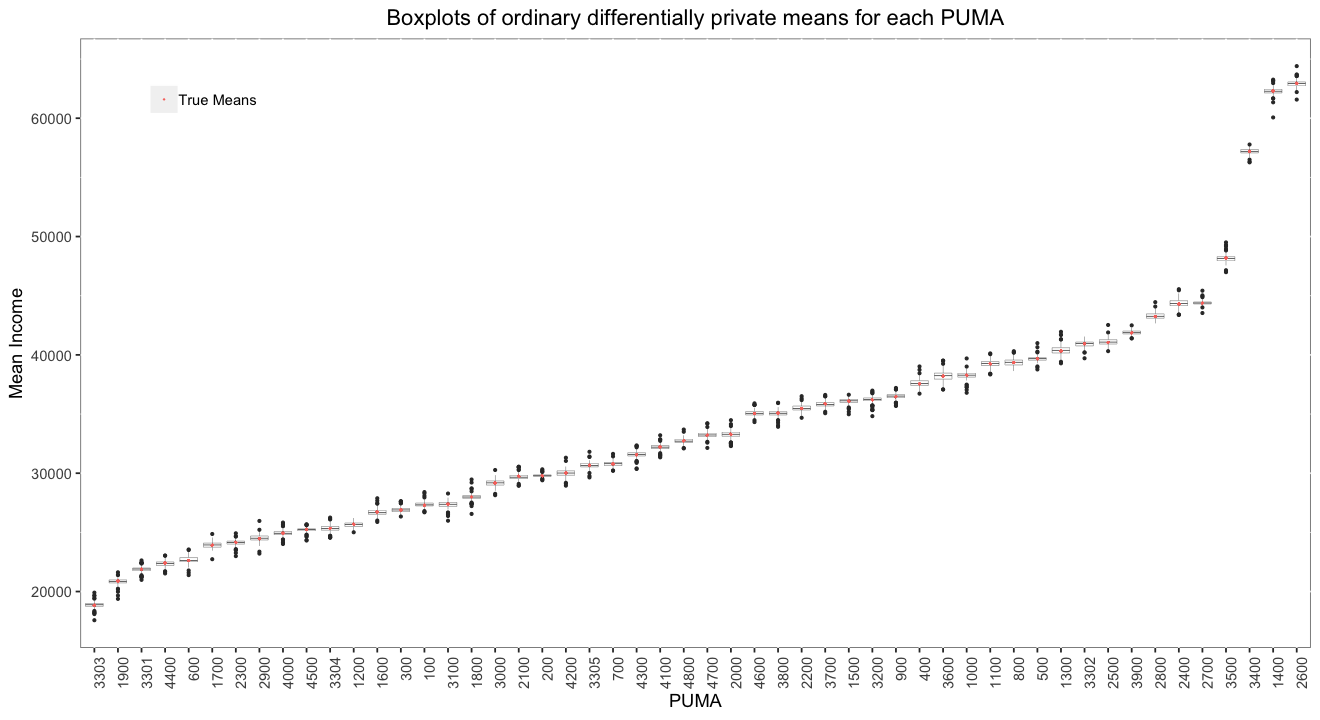

In [227]:
options(repr.plot.width=11, repr.plot.height=6)
pp1

In [228]:
pp2 <- ggplot(data = history.df[history.df$method == 2, ], 
            aes(x=reorder(factor(puma), truemean), y=DPmean)) + 
    geom_boxplot(lwd = 0.1, outlier.size = 0.5)+ 
    theme(plot.title = element_text(hjust = 0.5), axis.text.x = element_text(angle = 90, hjust = 1), 
          panel.background = element_rect(fill = "white", colour = "grey50"), legend.title = element_blank(), 
         legend.position = c(.1, .9)) +
    geom_point( aes(x=reorder(factor(puma), truemean), y=truemean, color = 'True Means'), shape=18, size = 0.5)+
    labs(x = "PUMA", y = 'Mean Income', title = 
         'Boxplots of trimmed differentially private means for each PUMA')

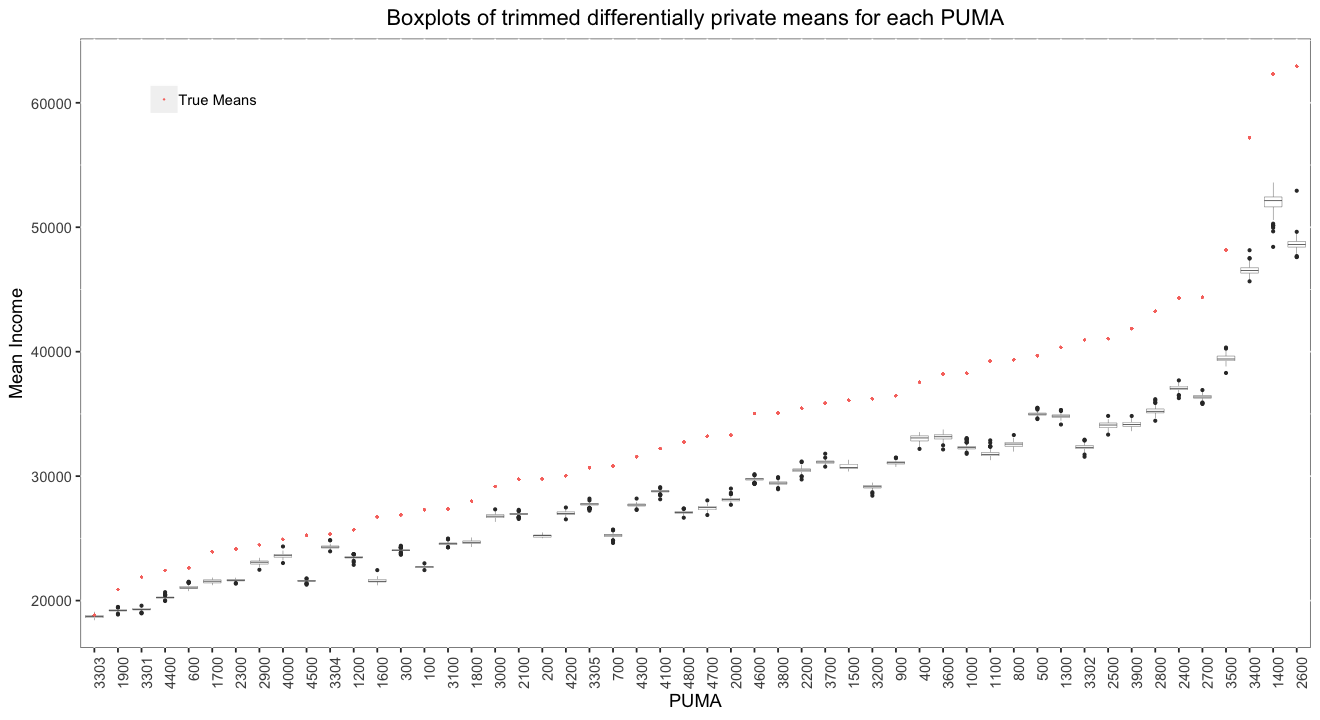

In [229]:
pp2

### Problem 2: 

<img src="q2.png" alt="Drawing" style="width: 700px;">


In [210]:
# Global Sensitivity of sums of Boolean predicates 
#          - changing one row changes the sum by at most 1
gs = 1

# Set Params
epsilon = 1
delta = 1e-09
max_k = 100

store_sds = matrix(NA, nrow = max_k, ncol = 3)

for(k in 1:max_k){
    # calculate the epsilons for each release
    eps_0_comp = epsilon/k
    eps_0_adv = epsilon/sqrt(2 * k * log(1/delta))
    
    # calculate optimal epsilon using PSI Library
    init <- rep(c(1/k, 0), k )
    params <- matrix(init, nrow=k, ncol=2, byrow=TRUE)
    inverse <- PSIlence:::update_parameters(params=params, hold=0, eps=epsilon, del=delta)
    eps_0_opt = inverse[1,1]
    
    # calculate standard deviation
    sds = sqrt(2) * c(gs/eps_0_comp, gs/eps_0_adv, gs/eps_0_opt)
    
    # store standard deviation
    store_sds[k, ] = sds
}

In [211]:
list_of_k = seq(1,100, 1)
sds.for.plot = data.frame(list_of_k, store_sds[,1], store_sds[,2], store_sds[,3])
names(sds.for.plot) <- c("list_of_k", "basic_comp", "advanced_comp", "optimal_comp")

## finding k where advanced and optimal comp yield lower sd for lap noise as cmopared to basic comp
k.where.adv.comp.wins = sds.for.plot[sds.for.plot$advanced_comp<sds.for.plot$basic_comp,][1,1]
k.where.opt.comp.wins = sds.for.plot[sds.for.plot$optimal_comp<sds.for.plot$basic_comp,][1,1]

# plot stuff
p1 <- ggplot(sds.for.plot) + 
    geom_line(aes(x=sds.for.plot$list_of_k, y=sds.for.plot$basic_comp, color = "Basic Composition")) +
    geom_line(aes(x=sds.for.plot$list_of_k, y=sds.for.plot$advanced_comp, color='Advanced Composition')) +
    geom_line(aes(x=sds.for.plot$list_of_k, y=sds.for.plot$optimal_comp, color='Optimal Composition')) +
    labs(x = "k", y = 'Standard Deviation', title = 
         'Standard Deviation of Laplace noise for \nincreasing number of queries, k') + 
    theme(plot.title = element_text(hjust = 0.5), legend.title = element_blank()) + 
    geom_vline(aes(xintercept=k.where.adv.comp.wins,),linetype = "longdash", alpha = 0.3) + 
    geom_text(aes(x=k.where.adv.comp.wins, label="k = 42", y=100), angle=90, vjust = 1.2)+

    geom_vline(aes(xintercept=k.where.opt.comp.wins,),linetype = "longdash", alpha = 0.3)+
    geom_text(aes(x=k.where.opt.comp.wins, label="k = 17", y=100), angle=90, vjust = 1.2)


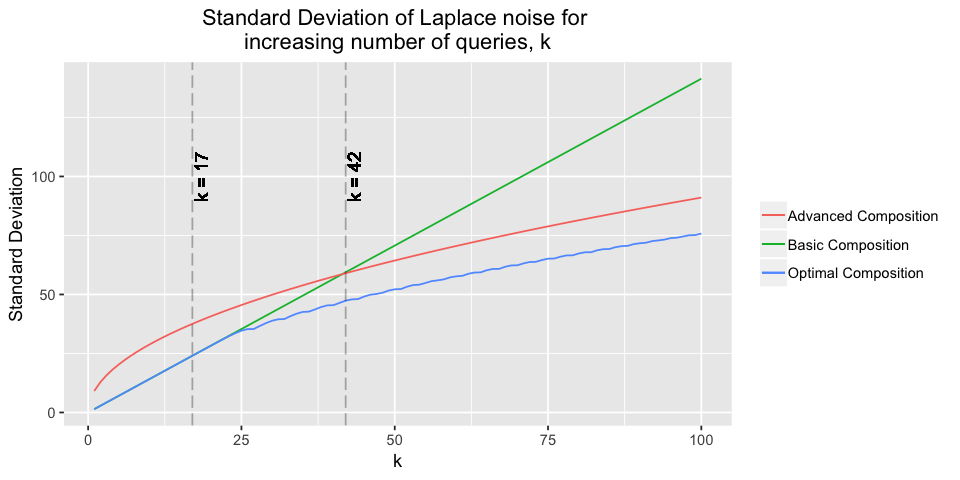

In [212]:
options(repr.plot.width=8, repr.plot.height=4)
p1

The plot of standard deviation of the Laplace noise added for increasing number of count queries released (k) shows that basic composition performs the worst, with standard deviation of the noise increasing linearly with the number of queries. Advanced composition performs worse than basic composition for a small number of queries (k < 42), but yields lower standard deviation needed for the Laplace noise, which results in released counts having higher utility. Similarly, optimal composition adds noise with the same standard deviation as basic composition up until k = 21, after which it decreases, yielding higher utility of the released counts.

### Problem 3: 

<img src="q3.png" alt="Drawing" style="width: 700px;">


In [239]:
data.educ <- PUMSdata$educ
data.inc <- PUMSdata$income
data.age <- PUMSdata$age

In [240]:
## Bound/Censor/Clip a variable to a range
clip <- function(x, lower, upper){
    x.clipped <- x
    x.clipped[x.clipped<lower] <- lower
    x.clipped[x.clipped>upper] <- upper
    return(x.clipped)
}

In [269]:
## Differentially private histogram for continuous
x1x2yHistogramRelease <- function(y, x1, x2,
                                ylower, yupper,
                                x1lower, x1upper,
                                x2lower, x2upper,
                                x1nbins = 0,
                                x2nbins = 0,
                                ynbins = 0,
                                epsilon){
    
    # get length of df essentially
    n <- nrow(x1)
    
    # clip data
    x1.clipped <- clip(x=x1, lower=x1lower, upper=x1upper)
    x2.clipped <- clip(x=x2, lower=x2lower, upper=x2upper)
    y.clipped <- log(clip(x=y, lower=1, upper=yupper))

    # preprocess the lower and upper bounds for y to convert to the log scale
    if(ylower == 0){
        ylower <- log(1)
    }
    yupper <- log(yupper)
    
    # populate x1 bins
    if(x1nbins==0){
        
        # get lower and upper values as integers
        x1lower <- floor(x1lower)
        x1upper <- ceiling(x1upper)
        
        # make vec of bins
        x1bins <- x1lower:(x1upper+1)    
        
        # extract # bins
        x1nbins <- length(x1bins)-1
        
        # distance between bins is granularity 
        x1granularity <- 1
        
        # just a codebook of bins used that will be output
        x1codebook <- x1bins[1:x1nbins]
        
    } else {
        
        # make a sequence of x1 values spaced out based on number of bins
        x1bins <- seq(from=x1lower, to=x1upper, length=x1nbins+1) # length is nbins + 1 because 
                                                                # we're looking at the number of endpoints of bins
        
        # get granularity
        x1granularity <- (x1upper-x1lower)/x1nbins
        
        # choose last elt of x1bins, which is the endpoint, 
        # and add granularity to it to capture the endpoints of the data
        x1bins[x1nbins+1] <-  x1bins[x1nbins+1] + x1granularity
        
        # Release midpoints of bins
        x1codebook <- x1bins[1:x1nbins] + 0.5*x1granularity
    }
    
    # populate x2 bins
    if(x2nbins==0){
        
        # get lower and upper values as integers
        x2lower <- floor(x2lower)
        x2upper <- ceiling(x2upper)
        
        # make vec of bins
        x2bins <- x2lower:(x2upper+1)    
        
        # extract # bins
        x2nbins <- length(x2bins)-1
        
        # distance between bins is granularity 
        x2granularity <- 1
        
        # just a codebook of bins used that will be output
        x2codebook <- x2bins[1:x2nbins]
        
    } else {
        
        # make a sequence of x1 values spaced out based on number of bins
        x2bins <- seq(from=x2lower, to=x2upper, length=x2nbins+1) # length is nbins + 1 because 
                                                                # we're looking at the number of endpoints of bins
        
        # get granularity
        x2granularity <- (x2upper-x2lower)/x2nbins
        
        # choose last elt of x1bins, which is the endpoint, 
        # and add granularity to it to capture the endpoints of the data
        x2bins[x2nbins+1] <-  x2bins[x2nbins+1] + x2granularity
        
        # Release midpoints of bins
        x2codebook <- x2bins[1:x2nbins] + 0.5*x2granularity
    }
    
    
    if(ynbins==0){
        
        # get lower and upper values as integers
        ylower <- floor(ylower)
        yupper <- ceiling(yupper)
        
        # make vec of bins
        ybins <- ylower:(yupper+1)
        
        # extract # bins
        ynbins <- length(ybins)-1
        
        # distance between bins is granularity 
        ygranularity <- 1
        
        # just a codebook of bins used that will be output
        ycodebook <- ybins[1:ynbins]
        
    } else {
            
        # make a sequence of y values spaced out based on number of bins
        ybins <- seq(from=ylower, to=yupper, length=ynbins+1) # length is nbins + 1 because 
                                                                # we're looking at the number of endpoints of bins
        
        # get granularity
        ygranularity <- (yupper-ylower)/ynbins
        
        # choose last elt of ybins, which is the endpoint, 
        # and add granularity to it to capture the endpoints of the data
        ybins[ynbins+1] <-  ybins[ynbins+1] + ygranularity
        
        # Release midpoints of bins
        ycodebook <- ybins[1:ynbins] + 0.5 * ygranularity    

    }
    
#     # clip data
#     x1.clipped <- clip(x=x1, lower=x1lower, upper=x1upper)
#     x2.clipped <- clip(x=x2, lower=x2lower, upper=x2upper)
#     y.clipped <- clip(x=y, lower=ylower, upper=yupper)

    # sensitivity of histogram release as in the change model, 
    #one person moves from one bin to another, changing both
    sensitivity <- 2
    scale <- sensitivity / epsilon

    sensitiveValue <- DPrelease <- matrix(NA, nrow=x1nbins * x2nbins * ynbins, ncol=4)
    
    counter = 1
    for(i in 1:x1nbins){
        for (j in 1:x2nbins){
            for (k in 1:ynbins){

                # calculate sensitive count in bin
                sensitiveBinVal <-  sum(x1.clipped >= x1bins[i] 
                                    & x1.clipped < x1bins[i+1] 
                                    & x2.clipped >= x2bins[j] 
                                    & x2.clipped < x2bins[j+1] 
                                    & y.clipped >= ybins[k] 
                                    & y.clipped < ybins[k+1])
                
                # add noise to sensitive val
                dpBinVal <- sensitiveBinVal + rlap(mu = 0, b = scale, size = 1)
                
                # populate matrices (sensitive and DP) with the bin value for x1, x2 and y
                sensitiveValue[counter,] <- c(x1codebook[i], x2codebook[j], ycodebook[k], sensitiveBinVal)
                DPrelease[counter,] <- c(x1codebook[i], x2codebook[j], ycodebook[k], dpBinVal)
                
                # update counter
                counter <- counter + 1
            }
        }
    }

    return(list(release=DPrelease, 
                true=sensitiveValue, 
                x1codebook=x1codebook, x2codebook=x2codebook, 
                ycodebook=ycodebook))
}

In [64]:
# Sys.time()
# check <- x1x2yHistogramRelease(y = data.inc, x1 = data.age, x2 = data.educ,
#                                # cap income at 1 mil
#                                 ylower = 0, yupper = 1e+06,
#                                # set age range b/w 18 and 100, based on age range for Census data collection
#                                 x1lower = 18, x1upper = 100,
#                                # education range based on codes
#                                 x2lower = 1, x2upper = 16,
#                                 x1nbins = 0,
#                                 x2nbins = 0,
#                                 ynbins = 10,
#                                 epsilon = 0.5)
# Sys.time()

[1] "2019-03-31 17:51:57 EDT"

[1] "2019-03-31 17:53:56 EDT"

### Problem 3: 

<img src="q3.png" alt="Drawing" style="width: 700px;">


In [250]:
## Post-process a vector or matrix of DP count releases, into probabilities
normalize <- function(x){
    x[x<0] <- 0
    x <- x/sum(x)
    return(x)
}

data.educ.lm <- clip(data.educ, lower=1, upper=16)
data.inc.lm <- clip(data.inc, lower=1, upper=1e+06)
data.age.lm <- clip(data.age, lower=18, upper=100)

true.output <- lm(log(data.inc.lm) ~ data.educ.lm + data.age.lm)
true.slope <- coef(true.output)[2]

In [327]:
true.output$coefficients

(Intercept) data.educ.lm  data.age.lm 
  6.07885272   0.21980434   0.01817699

In [328]:
# utility function to calculate RMSE
calcMSE <- function(true.val, pred.col){
    error = (true.val-pred.col)
    bias = (mean(error))
    var = var(pred.col)
    MSE = bias ** 2 + var
    return(list(bias = bias, var = var, MSE = MSE))
}

In [301]:
## Bootstrap the data to get an idea of sampling error via RMSE
n.boot = 1000
store.real.data.betas <- matrix(NA, nrow = n.boot, ncol = 3)

for(boots in 1:n.boot){
    indices.to.samp <- sample(x = 1:length(data.educ.lm), 
                             size = 10000, 
                             replace = TRUE)
    data.educ.lm.samp <- data.educ.lm[indices.to.samp]
    data.inc.lm.samp <- data.inc.lm[indices.to.samp]
    data.age.lm.samp <- data.age.lm[indices.to.samp]
    
    lm.output <- lm(log(data.inc.lm.samp) ~ data.educ.lm.samp + data.age.lm.samp)
    
    store.real.data.betas[boots, ] <- c(lm.output$coefficients[1], 
                              lm.output$coefficients[2], 
                              lm.output$coefficients[3])    
}

In [342]:
MSE.real.data.betas <- data.frame(matrix(NA, ncol = 4, nrow = 3))
names.for.betas <- c('Intercept', 'Education', 'Age')
for(i in 1:3){
    runMSE = calcMSE(true.output$coefficients[i], store.real.data.betas[,i])
    MSE.real.data.betas[i,] = c(names.for.betas[i], runMSE$bias, runMSE$var, runMSE$MSE)
}
names(MSE.real.data.betas) <- c('Variable', 'Bias', 'Variance', 'MSE')
MSE.real.data.betas

Variable,Bias,Variance,MSE
Intercept,-0.00955119298627942,0.0233814749095101,0.0234727001969713
Education,0.000683290719231842,0.000107696492911863,0.000108163379118851
Age,4.37336343146498e-05,2.5554753293348e-06,2.55738796010517e-06


> Write something about the bias variance crap

In [349]:
## build synthetic data
nsims <- 2

store.syn.betas <-matrix(NA, nrow=nsims, ncol=3)
Sys.time()
for(i in 1:nsims){
    out1 <- x1x2yHistogramRelease(y = data.inc, x1 = data.age, x2 = data.educ,
                                   # cap income at 1 mil
                                    ylower = 0, yupper = 1e+06,
                                   # set age range b/w 18 and 100, based on age range for Census data collection
                                    x1lower = 18, x1upper = 100,
                                   # education range based on codes
                                    x2lower = 1, x2upper = 16,
                                    x1nbins = 0,
                                    x2nbins = 0,
                                    ynbins = 10,
                                    epsilon = 1)
    
    # get probabilities
    syn.prob <- as.vector(normalize(out1$release[,4]))
    syn.sample.indices <- sample(x = 1:nrow(out1$release),
                                 size = nrow(out1$release),
                                 prob = syn.prob,
                                 replace = TRUE)
    
    # sample synthetic data
    syn.data <- out1$release[syn.sample.indices, ]

    output <- lm((syn.data[,3]) ~ syn.data[,1] + syn.data[,2])

    store.syn.betas[i,1] <- output$coef[1]
    store.syn.betas[i,2] <- output$coef[2]
    store.syn.betas[i,3] <- output$coef[3]
}
Sys.time()

[1] "2019-04-02 00:39:42 EDT"

[1] "2019-04-02 00:43:41 EDT"

In [350]:
store.syn.betas

6.354556,0.01348912,0.2088969
6.505684,0.01147921,0.2094612


In [354]:
df.betas <- as.data.frame(as.table(store.syn.betas))
write.csv(df.betas, file = "synthetic_betas.csv")

In [351]:
MSE.syn.data.betas <- data.frame(matrix(NA, ncol = 4, nrow = 3))
names.for.betas <- c('Intercept', 'Education', 'Age')
for(i in 1:3){
    runMSE = calcMSE(true.output$coefficients[i], store.syn.betas[,i])
    MSE.real.data.betas[i,] = c(names.for.betas[i], runMSE$bias, runMSE$var, runMSE$MSE)
}
names(MSE.syn.data.betas) <- c('Variable', 'Bias', 'Variance', 'MSE')
MSE.real.data.betas

Variable,Bias,Variance,MSE
Intercept,-0.351267185294725,0.0114197936347131,0.134808429099592
Education,0.207320176032125,2.01987222266944e-06,0.0429836752622138
Age,-0.191002078857911,1.59248287188672e-07,0.0364819533763307
